# InfVis project work
---
This Python Script downloads an up-to-date dataset for **Covid-19**, gives first insights on the data and exports the data to the data folder.

The Data is from the **R**obert **K**och **I**nstitut downloaded over [ArcGis Hub](https://hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6?page=15976).

*Script was created on Python: 3.7.6 64-bit Kernel*

## Importing and installing of required packages

In [47]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime

import io               # file operations
import json

import ssl              # secure client-server connection
import requests         # html-requests

In [10]:
# Uncomment next 2 lines to install jsonmerge
#import sys
#!{sys.executable} -m pip install jsonmerge
from jsonmerge import Merger

## Pulling the data from the internet

### Defining URL´s
URL´s are created from stringconcat.

In [11]:
sourceURL = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?'
objectIdsQuery = 'where=1%3D1&returnIdsOnly=true&f=json'
dataSetQuery = 'where=ObjectId+BETWEEN+0+AND+0' # just as an example gets created later dynamically
dataQuery = '&outSR=4326&outFields=IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn&f=json'

In [12]:
jsonMergeSchema = {"properties":{"features":{"mergeStrategy":"append"}}}
dataMerger = Merger(jsonMergeSchema)

### First request
Check local data and Identifies downloadable data.

In [33]:
# TODO check relevance
try:
    fobjectIds = open("../data/fobjectIds.json", "r+")
except FileNotFoundError: 
    fobjectIds = open("../data/fobjectIds.json", "w+")
    print('New File created')
    latestObjectId_old = 0
else:
    print('File found')
    objectIds_old = json.load(fobjectIds)
    fobjectIds.close()
    latestObjectId_old = objectIds_old['objectIds'][len(objectIds_old['objectIds']) - 1]
    print(f'Latest ObjectId: {latestObjectId_old}')

File found
Latest ObjectId: 21159421


In [14]:
objectIdsRequest = requests.get(sourceURL + objectIdsQuery)
objectIdsRequest.status_code

200

In [15]:
objectIds = json.loads(objectIdsRequest.text)

numOfObjectIds = len(objectIds['objectIds'])

objectIdStart = objectIds['objectIds'][0]
objectIdEnd = objectIds['objectIds'][numOfObjectIds - 1]
print(f'Range of ObjectIds: [{objectIdStart}, {objectIdEnd}]')

Range of ObjectIds: [20998268, 21159421]


In [34]:
with open('../data/fobjectIds.json', 'w') as f:
    json.dump(objectIds, f)
    f.close()

### Secound request
Determines eventual limit of data transfered by the server

In [17]:
dataRequest = requests.get(sourceURL + 'where=1%3D1' + dataQuery)
dataRequest.status_code

200

In [18]:
data = json.loads(dataRequest.text)
maxApiRequest = len(data['features'])

neededRequests = math.ceil(numOfObjectIds / maxApiRequest)

print(f'The download will require {neededRequests - 1} more requests due to the server limit of {maxApiRequest} features/request.')

The download will require 32 more requests due to the server limit of 5000 features/request.


Create all requests needed to get the data for every single ObjectId.  
**Ensure the cell above is run before this one is!**  
Otherwise it **WILL** cause data to be duplicated

In [19]:
i = 0
rangeLowerEnd = data['features'][maxApiRequest - 1]['attributes']['ObjectId'] + 1
rangeUpperEnd = rangeLowerEnd + maxApiRequest

while (i < neededRequests - 1): # neededRequests - 1 because of initial download
    dataSetQuery = f'where=ObjectId+BETWEEN+{rangeLowerEnd}+AND+{rangeUpperEnd}'
    temp_sourceURL = sourceURL + dataSetQuery + dataQuery
    #print(i, temp_sourceURL)
    print(i, f'Pulling ObjectIds: [{rangeLowerEnd}, {rangeUpperEnd}]')

    temp_dataRequest = requests.get(temp_sourceURL)
    if (temp_dataRequest.status_code > 200): # stop when a request isn´t working
        print(temp_dataRequest.status_code)
        break

    temp_data = json.loads(temp_dataRequest.text)

    data = dataMerger.merge(data, temp_data)

    temp_dataLength = len(data['features'])
    t_le = data['features'][0]['attributes']['ObjectId']
    t_ue = data['features'][temp_dataLength - 1]['attributes']['ObjectId']
    print(f'Total collected features: {temp_dataLength}', f'From ObjectIds: [{t_le}, {t_ue}]')

    rangeLowerEnd = rangeUpperEnd + 1
    rangeUpperEnd += maxApiRequest + 1
    if (rangeUpperEnd > objectIdEnd):
        rangeUpperEnd = objectIdEnd
    i += 1

print('Done')

0 Pulling ObjectIds: [21003268, 21008268]
Total collected features: 10000 From ObjectIds: [20998268, 21008267]
1 Pulling ObjectIds: [21008269, 21013269]
Total collected features: 15000 From ObjectIds: [20998268, 21013268]
2 Pulling ObjectIds: [21013270, 21018270]
Total collected features: 20000 From ObjectIds: [20998268, 21018269]
3 Pulling ObjectIds: [21018271, 21023271]
Total collected features: 25000 From ObjectIds: [20998268, 21023270]
4 Pulling ObjectIds: [21023272, 21028272]
Total collected features: 30000 From ObjectIds: [20998268, 21028271]
5 Pulling ObjectIds: [21028273, 21033273]
Total collected features: 35000 From ObjectIds: [20998268, 21033272]
6 Pulling ObjectIds: [21033274, 21038274]
Total collected features: 40000 From ObjectIds: [20998268, 21038273]
7 Pulling ObjectIds: [21038275, 21043275]
Total collected features: 45000 From ObjectIds: [20998268, 21043274]
8 Pulling ObjectIds: [21043276, 21048276]
Total collected features: 50000 From ObjectIds: [20998268, 21048275]
9

In [20]:
for item in data['fields']:
    print(item['name'])

IdBundesland
Bundesland
Landkreis
Altersgruppe
AnzahlFall
AnzahlTodesfall
ObjectId
Meldedatum
IdLandkreis
Datenstand
NeuerFall
NeuerTodesfall
Refdatum
NeuGenesen
AnzahlGenesen
IstErkrankungsbeginn


In [21]:
len(data['features'])

161123

In [22]:
totalCases = 0
for entry in data['features']:
    totalCases += entry['attributes']['AnzahlFall']
totalCases

199677

Testing commulated data for comparison with numbers from the internet

In [23]:
shDeaths = 0
shRecovered = 0
shEntries = 0
for entry in data['features']:
    if entry['attributes']['Bundesland'] == 'Schleswig-Holstein':
        shDeaths += entry['attributes']['AnzahlTodesfall']
        shRecovered += entry['attributes']['AnzahlGenesen']
        shEntries += 1
print('Deaths:', shDeaths, 'Recovered:', shRecovered, 'Entries:', shEntries)

Deaths: 154 Recovered: 3029 Entries: 2912


In [62]:
# reformatting the dates
for entry in data['features']:
    entry['attributes']['Meldedatum'] = datetime.fromtimestamp(entry['attributes']['Meldedatum'] / 1000).strftime("%x")
    entry['attributes']['Refdatum'] = datetime.fromtimestamp(entry['attributes']['Refdatum'] / 1000).strftime("%x")

In [35]:
with open('../data/rki_data.json', 'w') as f:
    json.dump(data, f)
    f.close()

## Creating Pandas DataFrame

In [24]:
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

In [63]:
dfx = pd.DataFrame.from_dict(data['features'])
display_n(dfx, 2)

,attributes
0,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
1,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
...,...
161121,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."
161122,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."


In [64]:
# turning the collumn attributes in seperated collumns
for rowid in data['fields']:
    dfx[rowid['name']] = dfx.apply(lambda row: row.loc['attributes'][rowid['name']], axis=1)
dfx = dfx.drop(['attributes'], axis=1)

In [65]:
display_n(dfx, 2)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,20998268,03/14/20,01001,"15.07.2020, 00:00 Uhr",0,-9,03/16/20,0,1,1
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,20998269,03/19/20,01001,"15.07.2020, 00:00 Uhr",0,-9,03/13/20,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161121,16,Thüringen,LK Altenburger Land,A80+,2,0,21159420,05/28/20,16077,"15.07.2020, 00:00 Uhr",0,-9,05/28/20,0,2,0
161122,16,Thüringen,LK Altenburger Land,A80+,1,0,21159421,06/09/20,16077,"15.07.2020, 00:00 Uhr",0,-9,06/09/20,0,1,0


In [28]:
frame_byBundesland = dfx.groupby(['Bundesland'])['AnzahlFall', 'AnzahlTodesfall', 'AnzahlGenesen'].sum().reset_index()
frame_byBundesland = frame_byBundesland.set_index('Bundesland')

,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Bundesland,,,
Baden-Württemberg,36157,1838,33801
Bayern,49416,2613,45920
...,...,...,...
Schleswig-Holstein,3228,154,3029
Thüringen,3300,182,3073


In [66]:
frame_byBundesland

,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Bundesland,,,
Bayern,49416,2613,45920
Nordrhein-Westfalen,45216,1708,41711
Baden-Württemberg,36157,1838,33801
Niedersachsen,13846,642,12952
Hessen,11215,514,10353
Berlin,8670,220,8094
Rheinland-Pfalz,7220,235,6816
Sachsen,5477,225,5198
Hamburg,5231,261,4916


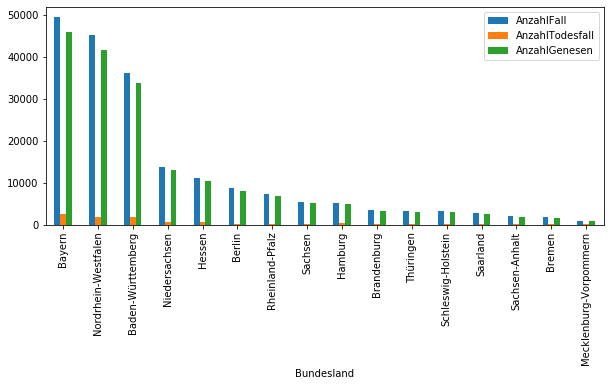

In [29]:
frame_byBundesland = frame_byBundesland.sort_values(by='AnzahlFall', ascending=False)
ax = frame_byBundesland.plot.bar(figsize=(10,4))